## Initial Structure to Relaxed Structure (IS2RS) <a name="is2rs"></a>

We approach the IS2RS task by using a pre-trained S2EF model to iteratively run a structure optimization to arrive at a relaxed structure. While the majority of approaches for this task do this iteratively, we note it's possible to train a model to directly predict relaxed structures.

## Steps for making IS2RS predictions
1) Define or load a configuration (config), which includes the following
* task with relaxation dataset information
* model
* optimizer
* dataset
* trainer

2) Create a ForcesTrainer object

3) Train a S2EF model or load an existing S2EF checkpoint

4) Run relaxations

**Note** For this task we'll be using a publicly released pre-trained checkpoint of our best model to perform relaxations.

#### Imports

In [25]:
from ocpmodels.trainers import ForcesTrainer
from ocpmodels.datasets import TrajectoryLmdbDataset
from ocpmodels import models
from ocpmodels.common import logger
from ocpmodels.common.utils import setup_logging
setup_logging()

import numpy as np

### Dataset

The IS2RS task requires an additional realxation dataset to be defined - `relax_dataset`. This dataset is read in similar to the IS2RE dataset - requiring an LMDB file. The same datasets are used for the IS2RE and IS2RS tasks.

In [26]:
train_src = "data/s2ef/train_100"
val_src = "data/s2ef/val_20"
relax_dataset = "data/is2re/val_20/data.lmdb"

In [27]:
train_src = '/home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/all/vasp_cal/train/'
val_src = '/home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/all/vasp_cal/val/'
relax_dataset = '/media/zwbai/DATA/dft/all/output/slab.lmdb'

### Download pretrained checkpoint

In [28]:
# !wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt
checkpoint_path = "../all/gemnet_t_direct_h512_all.pt"

### Define the Config

Running an iterative S2EF model for the IS2RS task can be run from any S2EF config given the following additions to the `task` portion of the config:

* relax_dataset - IS2RE LMDB dataset
* *write_pos* - Whether to save out relaxed positions
* *relaxation_steps* - Number of optimization steps to run
* *relax_opt* - Dictionary of optimizer settings. Currently only LBFGS supported
  * *maxstep* - Maximum distance an optimization is allowed to make
  * *memory* - Memory history to use for LBFGS
  * *damping* - Calculated step is multiplied by this factor before updating positions
  * *alpha* - Initial guess for the Hessian
  * *traj_dir* - If specified, directory to save out the full ML relaxation as an ASE trajectory. Useful for debugging or visualizing results.
* *num_relaxation_batches* - If specified, relaxations will only be run for a subset of the relaxation dataset. Useful for debugging or wanting to visualize a few systems.

A sample relaxation config can be found [here](https://github.com/Open-Catalyst-Project/ocp/blob/1044e311182c1120c6e6d137ce6db3f445148973/configs/s2ef/2M/dimenet_plus_plus/dpp_relax.yml#L24-L33).
   

In [29]:
# Task
task = {
    "dataset": "trajectory_lmdb",  # dataset used for the S2EF task
    "description": "Regressing to energies and forces for DFT trajectories from OCP",
    "type": "regression",
    "metric": "mae",
    "labels": ["potential energy"],
    "grad_input": "atomic forces",
    "train_on_free_atoms": True,
    "eval_on_free_atoms": True,
    "relax_dataset": {"src": relax_dataset},
    "write_pos": False,
    "relaxation_steps": 200,
    "num_relaxation_batches": 20,
    "relax_opt": {
        "maxstep": 0.04,
        "memory": 50,
        "damping": 1.0,
        "alpha": 70.0,
        "traj_dir": "ml-relaxations/is2rs-test",
    },
}
# Model
model = {
    "name": "gemnet_t",
    "num_spherical": 7,
    "num_radial": 128,
    "num_blocks": 3,
    "emb_size_atom": 512,
    "emb_size_edge": 512,
    "emb_size_trip": 64,
    "emb_size_rbf": 16,
    "emb_size_cbf": 16,
    "emb_size_bil_trip": 64,
    "num_before_skip": 1,
    "num_after_skip": 2,
    "num_concat": 1,
    "num_atom": 3,
    "cutoff": 6.0,
    "max_neighbors": 50,
    "rbf": {"name": "gaussian"},
    "envelope": {
        "name": "polynomial",
        "exponent": 5,
    },
    "cbf": {"name": "spherical_harmonics"},
    "extensive": True,
    "otf_graph": False,
    "output_init": "HeOrthogonal",
    "activation": "silu",
    "scale_file": "/home/zwbai/work/ocp-main/ocp/configs/s2ef/all/gemnet/scaling_factors/gemnet-dT.json",
    "regress_forces": True,
    "direct_forces": True,
}
# Optimizer
optimizer = {
    "batch_size": 1,  # originally 32
    "eval_batch_size": 1,  # originally 32
    "num_workers": 2,
    "lr_initial": 5.0e-4,
    "optimizer": "AdamW",
    "optimizer_params": {"amsgrad": True},
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.8,
    "ema_decay": 0.999,
    "clip_grad_norm": 10,
    "patience": 3,
    "max_epochs": 20,  # used for demonstration purposes
    "force_coefficient": 100,
}
# Dataset
dataset = [
    {"src": train_src, "normalize_labels": False},  # train set
    {"src": val_src},  # val set (optional)
]

### Create the trainer

In [30]:
trainer = ForcesTrainer(
    task=task,
    model=model,
    dataset=dataset,
    optimizer=optimizer,
    identifier="is2rs-example",
    run_dir="./", # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False, # if True, do not save checkpoint, logs, or results
    # is_vis=False,
    print_every=5,
    seed=0, # random seed to use
    logger="tensorboard", # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True, # use PyTorch Automatic Mixed Precision (faster training and less memory usage)
)

2023-12-28 15:48:21 (INFO): amp: true
cmd:
  checkpoint_dir: ./checkpoints/2023-12-28-15-49-20-is2rs-example
  commit: 9bc9373
  identifier: is2rs-example
  logs_dir: ./logs/tensorboard/2023-12-28-15-49-20-is2rs-example
  print_every: 5
  results_dir: ./results/2023-12-28-15-49-20-is2rs-example
  seed: 0
  timestamp_id: 2023-12-28-15-49-20-is2rs-example
dataset:
  normalize_labels: false
  src: /home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/all/vasp_cal/train/
gpus: 1
logger: tensorboard
model: gemnet_t
model_attributes:
  activation: silu
  cbf:
    name: spherical_harmonics
  cutoff: 6.0
  direct_forces: true
  emb_size_atom: 512
  emb_size_bil_trip: 64
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_rbf: 16
  emb_size_trip: 64
  envelope:
    exponent: 5
    name: polynomial
  extensive: true
  max_neighbors: 50
  num_after_skip: 2
  num_atom: 3
  num_before_skip: 1
  num_blocks: 3
  num_concat: 1
  num_radial: 128
  num_spherical: 7
  otf_graph: false
  output_init: HeOrthogona

2023-12-28 15:48:22 (WARNING): Model gradient logging to tensorboard not yet supported.


### Load the best checkpoint


In [31]:
# trainer.load_checkpoint(checkpoint_path=checkpoint_path)

### Run relaxations

We run a full relaxation for a single batch of our relaxation dataset (`num_relaxation_batches=1`).

In [32]:
trainer.run_relaxations()

2023-12-28 15:48:22 (INFO): Running ML-relaxations


  0%|          | 0/600 [00:00<?, ?it/s]

2023-12-28 15:48:22 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:23 (INFO): 0 15.452
2023-12-28 15:48:23 (INFO): 1 34.389
2023-12-28 15:48:23 (INFO): 2 18.377
2023-12-28 15:48:23 (INFO): 3 23.712
2023-12-28 15:48:23 (INFO): 4 7.195
2023-12-28 15:48:23 (INFO): 5 6.009
2023-12-28 15:48:23 (INFO): 6 6.212
2023-12-28 15:48:23 (INFO): 7 11.441
2023-12-28 15:48:23 (INFO): 8 6.515
2023-12-28 15:48:23 (INFO): 9 10.511
2023-12-28 15:48:23 (INFO): 10 12.440
2023-12-28 15:48:23 (INFO): 11 9.754
2023-12-28 15:48:23 (INFO): 12 10.883
2023-12-28 15:48:23 (INFO): 13 8.161
2023-12-28 15:48:23 (INFO): 14 7.819
2023-12-28 15:48:23 (INFO): 15 7.021
2023-12-28 15:48:23 (INFO): 16 6.607
2023-12-28 15:48:23 (INFO): 17 3.113
2023-12-28 15:48:23 (INFO): 18 6.092
2023-12-28 15:48:23 (INFO): 19 4.400
2023-12-28 15:48:23 (INFO): 20 5.385
2023-12-28 15:48:23 (INFO): 21 2.476
2023-12-28 15:48:23 (INFO): 22 8.847
2023-12-28 15:48:23 (INFO): 23 18.796
2023-12-28 15:48:23 (INFO): 24 7.539
2023-12-28 15:48:23 (INFO): 25

  0%|          | 1/600 [00:05<51:03,  5.11s/it]

2023-12-28 15:48:27 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:27 (INFO): 0 10.046
2023-12-28 15:48:27 (INFO): 1 6.420
2023-12-28 15:48:27 (INFO): 2 3.297
2023-12-28 15:48:27 (INFO): 3 6.413
2023-12-28 15:48:27 (INFO): 4 6.906
2023-12-28 15:48:27 (INFO): 5 7.889
2023-12-28 15:48:27 (INFO): 6 5.959
2023-12-28 15:48:27 (INFO): 7 6.465
2023-12-28 15:48:27 (INFO): 8 3.270
2023-12-28 15:48:27 (INFO): 9 3.880
2023-12-28 15:48:27 (INFO): 10 3.324
2023-12-28 15:48:27 (INFO): 11 3.806
2023-12-28 15:48:27 (INFO): 12 4.194
2023-12-28 15:48:27 (INFO): 13 3.497
2023-12-28 15:48:27 (INFO): 14 4.584
2023-12-28 15:48:27 (INFO): 15 3.433
2023-12-28 15:48:27 (INFO): 16 6.234
2023-12-28 15:48:27 (INFO): 17 4.639
2023-12-28 15:48:27 (INFO): 18 3.551
2023-12-28 15:48:27 (INFO): 19 2.814
2023-12-28 15:48:27 (INFO): 20 5.267
2023-12-28 15:48:27 (INFO): 21 2.755
2023-12-28 15:48:27 (INFO): 22 5.259
2023-12-28 15:48:28 (INFO): 23 3.612
2023-12-28 15:48:28 (INFO): 24 5.566
2023-12-28 15:48:28 (INFO): 25 6.899
2

  0%|          | 2/600 [00:09<45:27,  4.56s/it]

2023-12-28 15:48:31 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:31 (INFO): 0 4.573
2023-12-28 15:48:31 (INFO): 1 4.583
2023-12-28 15:48:31 (INFO): 2 19.798
2023-12-28 15:48:31 (INFO): 3 21.468
2023-12-28 15:48:31 (INFO): 4 20.151
2023-12-28 15:48:31 (INFO): 5 21.174
2023-12-28 15:48:31 (INFO): 6 5.174
2023-12-28 15:48:31 (INFO): 7 8.617
2023-12-28 15:48:31 (INFO): 8 7.475
2023-12-28 15:48:31 (INFO): 9 8.712
2023-12-28 15:48:31 (INFO): 10 8.391
2023-12-28 15:48:31 (INFO): 11 8.032
2023-12-28 15:48:31 (INFO): 12 5.875
2023-12-28 15:48:31 (INFO): 13 8.214
2023-12-28 15:48:32 (INFO): 14 5.902
2023-12-28 15:48:32 (INFO): 15 7.404
2023-12-28 15:48:32 (INFO): 16 6.720
2023-12-28 15:48:32 (INFO): 17 6.123
2023-12-28 15:48:32 (INFO): 18 6.284
2023-12-28 15:48:32 (INFO): 19 4.458
2023-12-28 15:48:32 (INFO): 20 6.949
2023-12-28 15:48:32 (INFO): 21 6.564
2023-12-28 15:48:32 (INFO): 22 4.683
2023-12-28 15:48:32 (INFO): 23 3.741
2023-12-28 15:48:32 (INFO): 24 5.340
2023-12-28 15:48:32 (INFO): 25 3.95

  0%|          | 3/600 [00:13<43:59,  4.42s/it]

2023-12-28 15:48:35 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:35 (INFO): 0 14.462
2023-12-28 15:48:35 (INFO): 1 4.382
2023-12-28 15:48:36 (INFO): 2 9.854
2023-12-28 15:48:36 (INFO): 3 7.632
2023-12-28 15:48:36 (INFO): 4 7.912
2023-12-28 15:48:36 (INFO): 5 8.324
2023-12-28 15:48:36 (INFO): 6 7.659
2023-12-28 15:48:36 (INFO): 7 8.473
2023-12-28 15:48:36 (INFO): 8 8.926
2023-12-28 15:48:36 (INFO): 9 9.444
2023-12-28 15:48:36 (INFO): 10 10.656
2023-12-28 15:48:36 (INFO): 11 14.414
2023-12-28 15:48:36 (INFO): 12 10.059
2023-12-28 15:48:36 (INFO): 13 5.742
2023-12-28 15:48:36 (INFO): 14 10.304
2023-12-28 15:48:36 (INFO): 15 7.034
2023-12-28 15:48:36 (INFO): 16 5.737
2023-12-28 15:48:36 (INFO): 17 7.683
2023-12-28 15:48:36 (INFO): 18 5.742
2023-12-28 15:48:36 (INFO): 19 5.432
2023-12-28 15:48:36 (INFO): 20 4.520
2023-12-28 15:48:36 (INFO): 21 5.748
2023-12-28 15:48:36 (INFO): 22 6.442
2023-12-28 15:48:36 (INFO): 23 6.323
2023-12-28 15:48:36 (INFO): 24 6.286
2023-12-28 15:48:36 (INFO): 25 5.6

  1%|          | 4/600 [00:17<43:26,  4.37s/it]

2023-12-28 15:48:40 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:40 (INFO): 0 4.620
2023-12-28 15:48:40 (INFO): 1 9.134
2023-12-28 15:48:40 (INFO): 2 3.561
2023-12-28 15:48:40 (INFO): 3 3.142
2023-12-28 15:48:40 (INFO): 4 4.083
2023-12-28 15:48:40 (INFO): 5 7.966
2023-12-28 15:48:40 (INFO): 6 4.639
2023-12-28 15:48:40 (INFO): 7 7.988
2023-12-28 15:48:40 (INFO): 8 4.625
2023-12-28 15:48:40 (INFO): 9 2.744
2023-12-28 15:48:40 (INFO): 10 4.604
2023-12-28 15:48:40 (INFO): 11 7.873
2023-12-28 15:48:40 (INFO): 12 4.713
2023-12-28 15:48:40 (INFO): 13 7.903
2023-12-28 15:48:40 (INFO): 14 6.386
2023-12-28 15:48:40 (INFO): 15 7.609
2023-12-28 15:48:40 (INFO): 16 5.812
2023-12-28 15:48:40 (INFO): 17 7.601
2023-12-28 15:48:40 (INFO): 18 6.777
2023-12-28 15:48:40 (INFO): 19 5.834
2023-12-28 15:48:40 (INFO): 20 5.771
2023-12-28 15:48:40 (INFO): 21 5.982
2023-12-28 15:48:40 (INFO): 22 5.601
2023-12-28 15:48:40 (INFO): 23 5.830
2023-12-28 15:48:40 (INFO): 24 5.608
2023-12-28 15:48:40 (INFO): 25 4.413
20

  1%|          | 5/600 [00:22<42:52,  4.32s/it]

2023-12-28 15:48:44 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:44 (INFO): 0 7.138
2023-12-28 15:48:44 (INFO): 1 6.978
2023-12-28 15:48:44 (INFO): 2 6.463
2023-12-28 15:48:44 (INFO): 3 8.036
2023-12-28 15:48:44 (INFO): 4 6.939
2023-12-28 15:48:44 (INFO): 5 12.443
2023-12-28 15:48:44 (INFO): 6 7.658
2023-12-28 15:48:44 (INFO): 7 5.084
2023-12-28 15:48:44 (INFO): 8 7.450
2023-12-28 15:48:44 (INFO): 9 4.993
2023-12-28 15:48:44 (INFO): 10 5.418
2023-12-28 15:48:44 (INFO): 11 4.989
2023-12-28 15:48:44 (INFO): 12 5.380
2023-12-28 15:48:44 (INFO): 13 6.648
2023-12-28 15:48:44 (INFO): 14 5.289
2023-12-28 15:48:44 (INFO): 15 4.766
2023-12-28 15:48:44 (INFO): 16 9.101
2023-12-28 15:48:44 (INFO): 17 4.348
2023-12-28 15:48:44 (INFO): 18 3.671
2023-12-28 15:48:44 (INFO): 19 4.106
2023-12-28 15:48:44 (INFO): 20 5.111
2023-12-28 15:48:44 (INFO): 21 4.496
2023-12-28 15:48:44 (INFO): 22 4.369
2023-12-28 15:48:44 (INFO): 23 3.589
2023-12-28 15:48:44 (INFO): 24 4.805
2023-12-28 15:48:45 (INFO): 25 3.903
2

  1%|          | 6/600 [00:26<42:22,  4.28s/it]

2023-12-28 15:48:48 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:48 (INFO): 0 6.262
2023-12-28 15:48:48 (INFO): 1 8.388
2023-12-28 15:48:48 (INFO): 2 15.457
2023-12-28 15:48:48 (INFO): 3 15.833
2023-12-28 15:48:48 (INFO): 4 9.310
2023-12-28 15:48:48 (INFO): 5 11.486
2023-12-28 15:48:48 (INFO): 6 4.181
2023-12-28 15:48:48 (INFO): 7 2.932
2023-12-28 15:48:48 (INFO): 8 5.570
2023-12-28 15:48:48 (INFO): 9 4.512
2023-12-28 15:48:48 (INFO): 10 5.039
2023-12-28 15:48:48 (INFO): 11 3.713
2023-12-28 15:48:48 (INFO): 12 5.753
2023-12-28 15:48:48 (INFO): 13 6.116
2023-12-28 15:48:48 (INFO): 14 4.151
2023-12-28 15:48:48 (INFO): 15 5.764
2023-12-28 15:48:49 (INFO): 16 4.237
2023-12-28 15:48:49 (INFO): 17 4.976
2023-12-28 15:48:49 (INFO): 18 5.588
2023-12-28 15:48:49 (INFO): 19 4.760
2023-12-28 15:48:49 (INFO): 20 4.787
2023-12-28 15:48:49 (INFO): 21 3.676
2023-12-28 15:48:49 (INFO): 22 6.410
2023-12-28 15:48:49 (INFO): 23 3.365
2023-12-28 15:48:49 (INFO): 24 5.830
2023-12-28 15:48:49 (INFO): 25 5.091

  1%|          | 7/600 [00:30<42:04,  4.26s/it]

2023-12-28 15:48:52 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:52 (INFO): 0 6.648
2023-12-28 15:48:52 (INFO): 1 5.182
2023-12-28 15:48:52 (INFO): 2 6.929
2023-12-28 15:48:52 (INFO): 3 4.872
2023-12-28 15:48:52 (INFO): 4 6.280
2023-12-28 15:48:52 (INFO): 5 5.916
2023-12-28 15:48:53 (INFO): 6 6.128
2023-12-28 15:48:53 (INFO): 7 5.966
2023-12-28 15:48:53 (INFO): 8 6.270
2023-12-28 15:48:53 (INFO): 9 4.243
2023-12-28 15:48:53 (INFO): 10 6.086
2023-12-28 15:48:53 (INFO): 11 6.003
2023-12-28 15:48:53 (INFO): 12 7.302
2023-12-28 15:48:53 (INFO): 13 8.156
2023-12-28 15:48:53 (INFO): 14 4.806
2023-12-28 15:48:53 (INFO): 15 9.480
2023-12-28 15:48:53 (INFO): 16 8.211
2023-12-28 15:48:53 (INFO): 17 5.066
2023-12-28 15:48:53 (INFO): 18 5.661
2023-12-28 15:48:53 (INFO): 19 4.578
2023-12-28 15:48:53 (INFO): 20 7.952
2023-12-28 15:48:53 (INFO): 21 4.926
2023-12-28 15:48:53 (INFO): 22 6.945
2023-12-28 15:48:53 (INFO): 23 6.188
2023-12-28 15:48:53 (INFO): 24 6.976
2023-12-28 15:48:53 (INFO): 25 3.303
20

  1%|▏         | 8/600 [00:34<41:50,  4.24s/it]

2023-12-28 15:48:57 (INFO): Step   Fmax(eV/A)
2023-12-28 15:48:57 (INFO): 0 16.330
2023-12-28 15:48:57 (INFO): 1 10.347
2023-12-28 15:48:57 (INFO): 2 5.526
2023-12-28 15:48:57 (INFO): 3 17.422
2023-12-28 15:48:57 (INFO): 4 16.779
2023-12-28 15:48:57 (INFO): 5 17.285
2023-12-28 15:48:57 (INFO): 6 12.126
2023-12-28 15:48:57 (INFO): 7 5.104
2023-12-28 15:48:57 (INFO): 8 4.692
2023-12-28 15:48:57 (INFO): 9 5.291
2023-12-28 15:48:57 (INFO): 10 6.324
2023-12-28 15:48:57 (INFO): 11 5.236
2023-12-28 15:48:57 (INFO): 12 4.333
2023-12-28 15:48:57 (INFO): 13 6.472
2023-12-28 15:48:57 (INFO): 14 9.850
2023-12-28 15:48:57 (INFO): 15 7.511
2023-12-28 15:48:57 (INFO): 16 3.558
2023-12-28 15:48:57 (INFO): 17 7.781
2023-12-28 15:48:57 (INFO): 18 3.566
2023-12-28 15:48:57 (INFO): 19 7.758
2023-12-28 15:48:57 (INFO): 20 3.562
2023-12-28 15:48:57 (INFO): 21 3.907
2023-12-28 15:48:57 (INFO): 22 5.715
2023-12-28 15:48:57 (INFO): 23 5.452
2023-12-28 15:48:57 (INFO): 24 5.991
2023-12-28 15:48:57 (INFO): 25 6.

  2%|▏         | 9/600 [00:38<41:45,  4.24s/it]

2023-12-28 15:49:01 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:01 (INFO): 0 5.697
2023-12-28 15:49:01 (INFO): 1 4.211
2023-12-28 15:49:01 (INFO): 2 18.959
2023-12-28 15:49:01 (INFO): 3 16.247
2023-12-28 15:49:01 (INFO): 4 9.911
2023-12-28 15:49:01 (INFO): 5 13.082
2023-12-28 15:49:01 (INFO): 6 6.038
2023-12-28 15:49:01 (INFO): 7 13.192
2023-12-28 15:49:01 (INFO): 8 5.317
2023-12-28 15:49:01 (INFO): 9 7.562
2023-12-28 15:49:01 (INFO): 10 9.029
2023-12-28 15:49:01 (INFO): 11 16.948
2023-12-28 15:49:01 (INFO): 12 18.615
2023-12-28 15:49:01 (INFO): 13 15.988
2023-12-28 15:49:01 (INFO): 14 10.279
2023-12-28 15:49:01 (INFO): 15 15.870
2023-12-28 15:49:01 (INFO): 16 6.871
2023-12-28 15:49:01 (INFO): 17 15.706
2023-12-28 15:49:01 (INFO): 18 22.469
2023-12-28 15:49:01 (INFO): 19 17.254
2023-12-28 15:49:01 (INFO): 20 22.623
2023-12-28 15:49:01 (INFO): 21 16.507
2023-12-28 15:49:01 (INFO): 22 19.400
2023-12-28 15:49:01 (INFO): 23 15.607
2023-12-28 15:49:01 (INFO): 24 14.733
2023-12-28 15:49:01 (I

  2%|▏         | 10/600 [00:43<41:36,  4.23s/it]

2023-12-28 15:49:05 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:05 (INFO): 0 10.334
2023-12-28 15:49:05 (INFO): 1 10.464
2023-12-28 15:49:05 (INFO): 2 2.178
2023-12-28 15:49:05 (INFO): 3 8.615
2023-12-28 15:49:05 (INFO): 4 4.295
2023-12-28 15:49:05 (INFO): 5 7.808
2023-12-28 15:49:05 (INFO): 6 4.958
2023-12-28 15:49:05 (INFO): 7 4.023
2023-12-28 15:49:05 (INFO): 8 4.126
2023-12-28 15:49:05 (INFO): 9 5.306
2023-12-28 15:49:05 (INFO): 10 5.398
2023-12-28 15:49:05 (INFO): 11 4.515
2023-12-28 15:49:05 (INFO): 12 3.449
2023-12-28 15:49:05 (INFO): 13 2.455
2023-12-28 15:49:05 (INFO): 14 3.892
2023-12-28 15:49:05 (INFO): 15 5.898
2023-12-28 15:49:05 (INFO): 16 5.146
2023-12-28 15:49:05 (INFO): 17 5.609
2023-12-28 15:49:05 (INFO): 18 5.074
2023-12-28 15:49:05 (INFO): 19 5.429
2023-12-28 15:49:05 (INFO): 20 5.052
2023-12-28 15:49:06 (INFO): 21 4.588
2023-12-28 15:49:06 (INFO): 22 5.249
2023-12-28 15:49:06 (INFO): 23 5.392
2023-12-28 15:49:06 (INFO): 24 4.867
2023-12-28 15:49:06 (INFO): 25 5.054


  2%|▏         | 11/600 [00:47<41:36,  4.24s/it]

2023-12-28 15:49:09 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:09 (INFO): 0 14.142
2023-12-28 15:49:09 (INFO): 1 13.121
2023-12-28 15:49:09 (INFO): 2 7.297
2023-12-28 15:49:09 (INFO): 3 20.130
2023-12-28 15:49:09 (INFO): 4 9.918
2023-12-28 15:49:09 (INFO): 5 8.344
2023-12-28 15:49:09 (INFO): 6 8.612
2023-12-28 15:49:09 (INFO): 7 10.987
2023-12-28 15:49:09 (INFO): 8 11.593
2023-12-28 15:49:09 (INFO): 9 9.817
2023-12-28 15:49:10 (INFO): 10 9.752
2023-12-28 15:49:10 (INFO): 11 15.699
2023-12-28 15:49:10 (INFO): 12 10.614
2023-12-28 15:49:10 (INFO): 13 12.055
2023-12-28 15:49:10 (INFO): 14 5.028
2023-12-28 15:49:10 (INFO): 15 4.303
2023-12-28 15:49:10 (INFO): 16 5.200
2023-12-28 15:49:10 (INFO): 17 5.678
2023-12-28 15:49:10 (INFO): 18 7.067
2023-12-28 15:49:10 (INFO): 19 8.068
2023-12-28 15:49:10 (INFO): 20 7.513
2023-12-28 15:49:10 (INFO): 21 7.468
2023-12-28 15:49:10 (INFO): 22 6.239
2023-12-28 15:49:10 (INFO): 23 7.641
2023-12-28 15:49:10 (INFO): 24 7.314
2023-12-28 15:49:10 (INFO): 25 

  2%|▏         | 12/600 [00:51<41:40,  4.25s/it]

2023-12-28 15:49:14 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:14 (INFO): 0 10.277
2023-12-28 15:49:14 (INFO): 1 5.085
2023-12-28 15:49:14 (INFO): 2 3.461
2023-12-28 15:49:14 (INFO): 3 6.524
2023-12-28 15:49:14 (INFO): 4 4.253
2023-12-28 15:49:14 (INFO): 5 6.329
2023-12-28 15:49:14 (INFO): 6 8.486
2023-12-28 15:49:14 (INFO): 7 3.056
2023-12-28 15:49:14 (INFO): 8 6.552
2023-12-28 15:49:14 (INFO): 9 7.544
2023-12-28 15:49:14 (INFO): 10 8.355
2023-12-28 15:49:14 (INFO): 11 7.946
2023-12-28 15:49:14 (INFO): 12 5.197
2023-12-28 15:49:14 (INFO): 13 5.398
2023-12-28 15:49:14 (INFO): 14 12.749
2023-12-28 15:49:14 (INFO): 15 5.353
2023-12-28 15:49:14 (INFO): 16 10.166
2023-12-28 15:49:14 (INFO): 17 8.305
2023-12-28 15:49:14 (INFO): 18 21.603
2023-12-28 15:49:14 (INFO): 19 14.171
2023-12-28 15:49:14 (INFO): 20 8.629
2023-12-28 15:49:14 (INFO): 21 14.695
2023-12-28 15:49:14 (INFO): 22 15.308
2023-12-28 15:49:14 (INFO): 23 13.091
2023-12-28 15:49:14 (INFO): 24 19.785
2023-12-28 15:49:14 (INFO): 25

  2%|▏         | 13/600 [00:55<41:36,  4.25s/it]

2023-12-28 15:49:18 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:18 (INFO): 0 12.943
2023-12-28 15:49:18 (INFO): 1 18.351
2023-12-28 15:49:18 (INFO): 2 3.697
2023-12-28 15:49:18 (INFO): 3 7.723
2023-12-28 15:49:18 (INFO): 4 7.406
2023-12-28 15:49:18 (INFO): 5 7.615
2023-12-28 15:49:18 (INFO): 6 4.564
2023-12-28 15:49:18 (INFO): 7 17.192
2023-12-28 15:49:18 (INFO): 8 7.071
2023-12-28 15:49:18 (INFO): 9 12.490
2023-12-28 15:49:18 (INFO): 10 6.898
2023-12-28 15:49:18 (INFO): 11 7.770
2023-12-28 15:49:18 (INFO): 12 9.840
2023-12-28 15:49:18 (INFO): 13 7.312
2023-12-28 15:49:18 (INFO): 14 11.600
2023-12-28 15:49:18 (INFO): 15 7.275
2023-12-28 15:49:18 (INFO): 16 10.167
2023-12-28 15:49:18 (INFO): 17 5.237
2023-12-28 15:49:18 (INFO): 18 8.857
2023-12-28 15:49:18 (INFO): 19 5.215
2023-12-28 15:49:18 (INFO): 20 5.723
2023-12-28 15:49:18 (INFO): 21 6.510
2023-12-28 15:49:18 (INFO): 22 5.337
2023-12-28 15:49:18 (INFO): 23 5.809
2023-12-28 15:49:18 (INFO): 24 7.214
2023-12-28 15:49:18 (INFO): 25 6.

  2%|▏         | 14/600 [01:00<41:27,  4.24s/it]

2023-12-28 15:49:22 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:22 (INFO): 0 4.301
2023-12-28 15:49:22 (INFO): 1 9.203
2023-12-28 15:49:22 (INFO): 2 8.558
2023-12-28 15:49:22 (INFO): 3 6.898
2023-12-28 15:49:22 (INFO): 4 5.431
2023-12-28 15:49:22 (INFO): 5 9.014
2023-12-28 15:49:22 (INFO): 6 6.453
2023-12-28 15:49:22 (INFO): 7 5.299
2023-12-28 15:49:22 (INFO): 8 5.753
2023-12-28 15:49:22 (INFO): 9 4.836
2023-12-28 15:49:22 (INFO): 10 3.782
2023-12-28 15:49:22 (INFO): 11 5.753
2023-12-28 15:49:22 (INFO): 12 6.062
2023-12-28 15:49:22 (INFO): 13 5.924
2023-12-28 15:49:22 (INFO): 14 6.412
2023-12-28 15:49:22 (INFO): 15 5.990
2023-12-28 15:49:22 (INFO): 16 6.299
2023-12-28 15:49:22 (INFO): 17 6.415
2023-12-28 15:49:22 (INFO): 18 6.328
2023-12-28 15:49:22 (INFO): 19 6.303
2023-12-28 15:49:22 (INFO): 20 6.280
2023-12-28 15:49:23 (INFO): 21 6.273
2023-12-28 15:49:23 (INFO): 22 6.291
2023-12-28 15:49:23 (INFO): 23 5.998
2023-12-28 15:49:23 (INFO): 24 6.263
2023-12-28 15:49:23 (INFO): 25 5.580
20

  2%|▎         | 15/600 [01:04<41:08,  4.22s/it]

2023-12-28 15:49:26 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:26 (INFO): 0 6.505
2023-12-28 15:49:26 (INFO): 1 12.510
2023-12-28 15:49:26 (INFO): 2 8.038
2023-12-28 15:49:26 (INFO): 3 8.339
2023-12-28 15:49:26 (INFO): 4 5.093
2023-12-28 15:49:26 (INFO): 5 4.355
2023-12-28 15:49:26 (INFO): 6 5.167
2023-12-28 15:49:26 (INFO): 7 6.455
2023-12-28 15:49:26 (INFO): 8 5.023
2023-12-28 15:49:26 (INFO): 9 4.339
2023-12-28 15:49:26 (INFO): 10 7.134
2023-12-28 15:49:26 (INFO): 11 3.002
2023-12-28 15:49:26 (INFO): 12 3.544
2023-12-28 15:49:27 (INFO): 13 3.463
2023-12-28 15:49:27 (INFO): 14 3.125
2023-12-28 15:49:27 (INFO): 15 4.865
2023-12-28 15:49:27 (INFO): 16 6.847
2023-12-28 15:49:27 (INFO): 17 4.833
2023-12-28 15:49:27 (INFO): 18 6.885
2023-12-28 15:49:27 (INFO): 19 4.796
2023-12-28 15:49:27 (INFO): 20 6.903
2023-12-28 15:49:27 (INFO): 21 8.589
2023-12-28 15:49:27 (INFO): 22 7.379
2023-12-28 15:49:27 (INFO): 23 7.000
2023-12-28 15:49:27 (INFO): 24 7.592
2023-12-28 15:49:27 (INFO): 25 7.871
2

  3%|▎         | 16/600 [01:08<41:03,  4.22s/it]

2023-12-28 15:49:30 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:30 (INFO): 0 12.578
2023-12-28 15:49:30 (INFO): 1 7.317
2023-12-28 15:49:30 (INFO): 2 16.026
2023-12-28 15:49:31 (INFO): 3 6.859
2023-12-28 15:49:31 (INFO): 4 6.895
2023-12-28 15:49:31 (INFO): 5 9.669
2023-12-28 15:49:31 (INFO): 6 9.240
2023-12-28 15:49:31 (INFO): 7 9.367
2023-12-28 15:49:31 (INFO): 8 8.610
2023-12-28 15:49:31 (INFO): 9 8.887
2023-12-28 15:49:31 (INFO): 10 8.324
2023-12-28 15:49:31 (INFO): 11 8.890
2023-12-28 15:49:31 (INFO): 12 8.583
2023-12-28 15:49:31 (INFO): 13 9.549
2023-12-28 15:49:31 (INFO): 14 6.756
2023-12-28 15:49:31 (INFO): 15 5.994
2023-12-28 15:49:31 (INFO): 16 6.185
2023-12-28 15:49:31 (INFO): 17 8.800
2023-12-28 15:49:31 (INFO): 18 5.802
2023-12-28 15:49:31 (INFO): 19 8.755
2023-12-28 15:49:31 (INFO): 20 9.348
2023-12-28 15:49:31 (INFO): 21 8.906
2023-12-28 15:49:31 (INFO): 22 8.939
2023-12-28 15:49:31 (INFO): 23 8.462
2023-12-28 15:49:31 (INFO): 24 7.065
2023-12-28 15:49:31 (INFO): 25 5.609


  3%|▎         | 17/600 [01:12<40:58,  4.22s/it]

2023-12-28 15:49:35 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:35 (INFO): 0 8.635
2023-12-28 15:49:35 (INFO): 1 5.983
2023-12-28 15:49:35 (INFO): 2 2.709
2023-12-28 15:49:35 (INFO): 3 7.508
2023-12-28 15:49:35 (INFO): 4 7.553
2023-12-28 15:49:35 (INFO): 5 6.622
2023-12-28 15:49:35 (INFO): 6 4.320
2023-12-28 15:49:35 (INFO): 7 4.263
2023-12-28 15:49:35 (INFO): 8 4.164
2023-12-28 15:49:35 (INFO): 9 3.952
2023-12-28 15:49:35 (INFO): 10 6.253
2023-12-28 15:49:35 (INFO): 11 8.692
2023-12-28 15:49:35 (INFO): 12 6.094
2023-12-28 15:49:35 (INFO): 13 4.566
2023-12-28 15:49:35 (INFO): 14 4.634
2023-12-28 15:49:35 (INFO): 15 2.370
2023-12-28 15:49:35 (INFO): 16 4.907
2023-12-28 15:49:35 (INFO): 17 11.014
2023-12-28 15:49:35 (INFO): 18 6.530
2023-12-28 15:49:35 (INFO): 19 7.994
2023-12-28 15:49:35 (INFO): 20 3.339
2023-12-28 15:49:35 (INFO): 21 11.350
2023-12-28 15:49:35 (INFO): 22 5.123
2023-12-28 15:49:35 (INFO): 23 12.189
2023-12-28 15:49:35 (INFO): 24 6.312
2023-12-28 15:49:35 (INFO): 25 13.38

  3%|▎         | 18/600 [01:16<40:52,  4.21s/it]

2023-12-28 15:49:39 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:39 (INFO): 0 11.132
2023-12-28 15:49:39 (INFO): 1 22.442
2023-12-28 15:49:39 (INFO): 2 9.113
2023-12-28 15:49:39 (INFO): 3 10.098
2023-12-28 15:49:39 (INFO): 4 10.861
2023-12-28 15:49:39 (INFO): 5 10.648
2023-12-28 15:49:39 (INFO): 6 7.174
2023-12-28 15:49:39 (INFO): 7 8.578
2023-12-28 15:49:39 (INFO): 8 14.443
2023-12-28 15:49:39 (INFO): 9 9.391
2023-12-28 15:49:39 (INFO): 10 2.147
2023-12-28 15:49:39 (INFO): 11 1.925
2023-12-28 15:49:39 (INFO): 12 3.640
2023-12-28 15:49:39 (INFO): 13 6.458
2023-12-28 15:49:39 (INFO): 14 3.831
2023-12-28 15:49:39 (INFO): 15 2.733
2023-12-28 15:49:39 (INFO): 16 4.561
2023-12-28 15:49:39 (INFO): 17 1.660
2023-12-28 15:49:39 (INFO): 18 2.432
2023-12-28 15:49:39 (INFO): 19 2.104
2023-12-28 15:49:39 (INFO): 20 3.932
2023-12-28 15:49:39 (INFO): 21 1.747
2023-12-28 15:49:39 (INFO): 22 1.907
2023-12-28 15:49:39 (INFO): 23 1.858
2023-12-28 15:49:39 (INFO): 24 3.842
2023-12-28 15:49:39 (INFO): 25 1.

  3%|▎         | 19/600 [01:21<40:48,  4.21s/it]

2023-12-28 15:49:43 (INFO): Step   Fmax(eV/A)
2023-12-28 15:49:43 (INFO): 0 8.403
2023-12-28 15:49:43 (INFO): 1 9.279
2023-12-28 15:49:43 (INFO): 2 4.338
2023-12-28 15:49:43 (INFO): 3 8.705
2023-12-28 15:49:43 (INFO): 4 4.081
2023-12-28 15:49:43 (INFO): 5 11.643
2023-12-28 15:49:43 (INFO): 6 6.987
2023-12-28 15:49:43 (INFO): 7 3.003
2023-12-28 15:49:43 (INFO): 8 5.233
2023-12-28 15:49:43 (INFO): 9 3.567
2023-12-28 15:49:43 (INFO): 10 10.108
2023-12-28 15:49:43 (INFO): 11 2.881
2023-12-28 15:49:43 (INFO): 12 4.740
2023-12-28 15:49:43 (INFO): 13 3.908
2023-12-28 15:49:43 (INFO): 14 3.807
2023-12-28 15:49:43 (INFO): 15 3.441
2023-12-28 15:49:43 (INFO): 16 2.634
2023-12-28 15:49:43 (INFO): 17 3.350
2023-12-28 15:49:43 (INFO): 18 4.591
2023-12-28 15:49:43 (INFO): 19 2.711
2023-12-28 15:49:44 (INFO): 20 2.103
2023-12-28 15:49:44 (INFO): 21 4.490
2023-12-28 15:49:44 (INFO): 22 5.515
2023-12-28 15:49:44 (INFO): 23 4.342
2023-12-28 15:49:44 (INFO): 24 3.318
2023-12-28 15:49:44 (INFO): 25 4.027


  3%|▎         | 20/600 [01:25<41:16,  4.27s/it]

2023-12-28 15:49:47 (INFO): {'average_distance_within_threshold': {'total': 4403, 'numel': 9800, 'metric': 0.4492857142857143}, 'positions_mae': {'total': 16.61638605594635, 'numel': 120, 'metric': 0.1384698837995529}, 'positions_mse': {'total': 4.226914618164301, 'numel': 120, 'metric': 0.03522428848470251}}
2023-12-28 15:49:47 (INFO): {'energy_mae': {'total': 327.21420669555664, 'numel': 20, 'metric': 16.36071033477783}, 'energy_mse': {'total': 7128.757377147675, 'numel': 20, 'metric': 356.4378688573837}, 'energy_within_threshold': {'total': 0, 'numel': 20, 'metric': 0.0}}


### Visualize ML-driven relaxations

Following our earlier [visualization steps](#data-description), we can plot our ML-generated relaxations.

In [33]:
import glob
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import random
import matplotlib

params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'font.family': ' DejaVu Sans',
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'axes.labelsize': 25,
   'axes.titlesize': 25,
   'text.usetex': False,
   'figure.figsize': [12, 12]
}
matplotlib.rcParams.update(params)

'ml-relaxations/is2rs-test/2.traj'

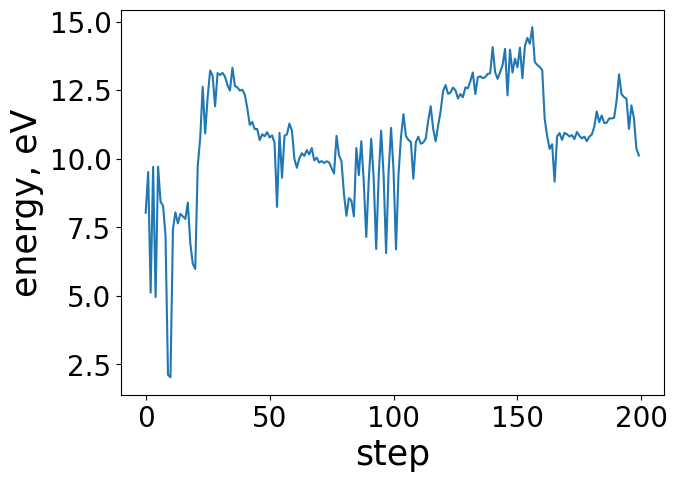

In [34]:
system = glob.glob("ml-relaxations/is2rs-test/*.traj")[0]
ml_trajectory = ase.io.read(system, ":")

energies = [atom.get_potential_energy() for atom in ml_trajectory]

plt.figure(figsize=(7, 5))
plt.plot(range(len(energies)), energies)
plt.xlabel("step")
plt.ylabel("energy, eV")
system

In [35]:
system

'ml-relaxations/is2rs-test/2.traj'

Qualitatively, the ML relaxation is behaving as expected - decreasing energies over the course of the relaxation.

<Axes: title={'center': 'ml-final'}>

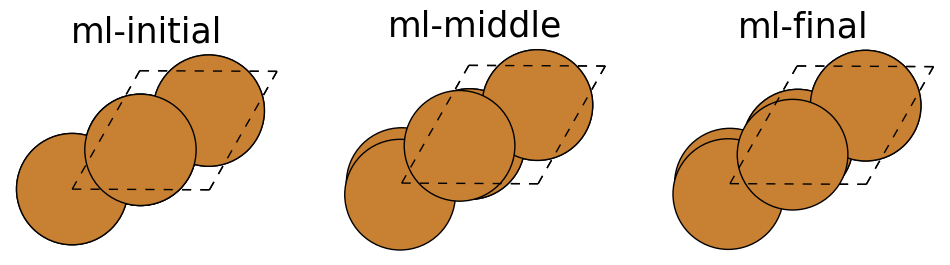

In [36]:
fig, ax = plt.subplots(1, 3)
labels = ['ml-initial', 'ml-middle', 'ml-final']
for i in range(3):
    ax[i].axis('off')
    ax[i].set_title(labels[i])

ase.visualize.plot.plot_atoms(
    ml_trajectory[0], 
    ax[0], 
    radii=0.8,
    # rotation=("-75x, 45y, 10z")) # uncomment to visualize at different angles
)
ase.visualize.plot.plot_atoms(
    ml_trajectory[100], 
    ax[1], 
    radii=0.8, 
    # rotation=("-75x, 45y, 10z") # uncomment to visualize at different angles
)
ase.visualize.plot.plot_atoms(
    ml_trajectory[-1], 
    ax[2], 
    radii=0.8,
    # rotation=("-75x, 45y, 10z"), # uncomment to visualize at different angles
)
